In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import pydicom as dcm
import os
print(os.listdir("../input"))

['stage_2_test_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_images', 'stage_2_train_labels.csv', 'GCP Credits Request Link - RSNA.txt']


In [2]:
labels = pd.read_csv("../input/stage_2_train_labels.csv")
class_info  = pd.read_csv("../input/stage_2_detailed_class_info.csv")

In [3]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
labels.drop(['x', 'y', 'width', 'height'], axis=1, inplace=True)

In [6]:
len(labels.patientId.unique())

26684

In [7]:
#There are 30227 rows of data and only 26684 unique patients in the dataset, lets see the number of images in the train set to determine if the labels set has any duplicates.
image_train_path = os.listdir('../input/stage_2_train_images')
print("Number of images in train set:", len(image_train_path))



Number of images in train set: 26684


In [8]:
#There are only 26684 images in the train set, so there are duplicates in the datasets

labels_1 = labels.groupby('patientId')['patientId'].count().reset_index(name = 'counts')
labels_2 = labels_1.loc[labels_1.counts > 1, ]
dup_patient_list = list(labels_2['patientId'])

In [9]:
dup_patients = labels[labels['patientId'].isin(dup_patient_list)]
dup_patients.Target.unique() # all the duplicate patient IDs have same Target of 1 so its safe to drop the duplicates
labels.drop_duplicates(inplace=True)

In [10]:
labels.shape

(26684, 2)

In [11]:
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [12]:
class_info.shape

(30227, 2)

In [13]:
len(class_info.patientId.unique()) # there are only 26684 unique patients in the dataset, lets see if there are any duplicates

26684

In [14]:
class_info_1 = class_info.groupby('patientId')['patientId'].count().reset_index(name = 'counts')
class_info_2 = class_info_1.loc[labels_1.counts > 1, ]
dup_patient_list1 = list(class_info_2['patientId'])

In [15]:
dup_patients1 = class_info[class_info['patientId'].isin(dup_patient_list1)]
dup_patients1['class'].unique() # all the duplicate patient IDs have same class of 'Lung Opacity' so its safe to drop the duplicates
class_info.drop_duplicates(inplace=True)

In [16]:
class_info.shape

(26684, 2)

In [17]:
#Lets explore the two datasets
labels.groupby('Target').count()

,patientId
Target,
0,20672
1,6012


In [18]:
class_info.groupby('class').count()

,patientId
class,
Lung Opacity,6012
No Lung Opacity / Not Normal,11821
Normal,8851


In [19]:
#lets merge labels and class_info
data = labels.merge(class_info, on='patientId')

In [20]:
data.shape

(26684, 3)

In [21]:
data.head(20)

,patientId,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity
5,00569f44-917d-4c86-a842-81832af98c30,0,No Lung Opacity / Not Normal
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0,No Lung Opacity / Not Normal
7,00704310-78a8-4b38-8475-49f4573b2dbb,1,Lung Opacity
8,008c19e8-a820-403a-930a-bc74a4053664,0,No Lung Opacity / Not Normal
9,009482dc-3db5-48d4-8580-5c89c4f01334,0,Normal


In [22]:
samplePatientID = list(data[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("../input/stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

We can observe that we do have available some useful information in the DICOM metadata with predictive value, for example:

Patient sex;
Patient age;
Modality;
Body part examined;
View position;
Rows & Columns;
Pixel Spacing.

### Train data

We will parse the DICOM meta information and add it to the train dataset. We will do the same with the test data.

In [23]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])

In [24]:
process_dicom_data(data,'../input/stage_2_train_images/')

In [25]:
data.to_csv('data.csv')

Let's get into more details for the train dataset. First, let's check the distribution of PA and AP.



In [26]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

In [27]:
get_feature_distribution(data,'ViewPosition')

Feature: ViewPosition
PA                            :   14511 or 54.38%
AP                            :   12173 or 45.61%


Both AP and PA body positions are present in the data. The meaning of these view positions are:

AP - Anterior/Posterior;

PA - Posterior/Anterior.

Patient Age

Let's examine now the data for the Patient Age for the train set.

In [28]:
tmp = data.groupby(['Target', 'PatientAge'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientAge']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

In [29]:
tmp = data.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

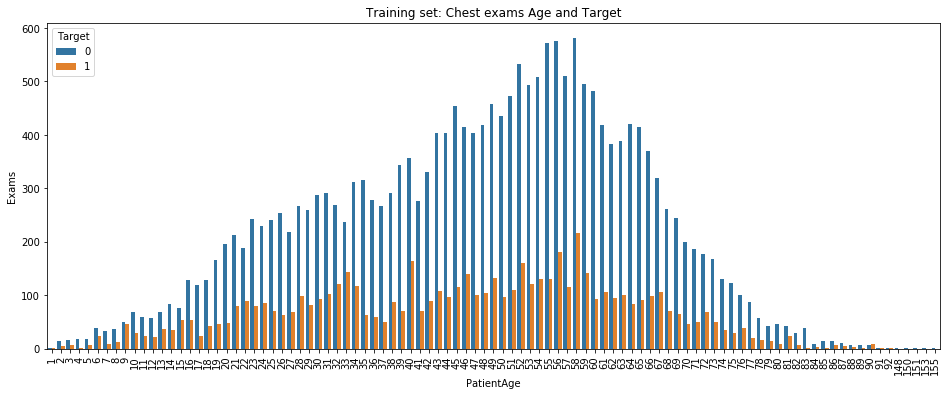

<Figure size 432x288 with 0 Axes>

In [30]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='Target',data=df2)
plt.title("Training set: Chest exams Age and Target")
plt.xticks(rotation=90)
plt.show()
plt.savefig('patient.png')

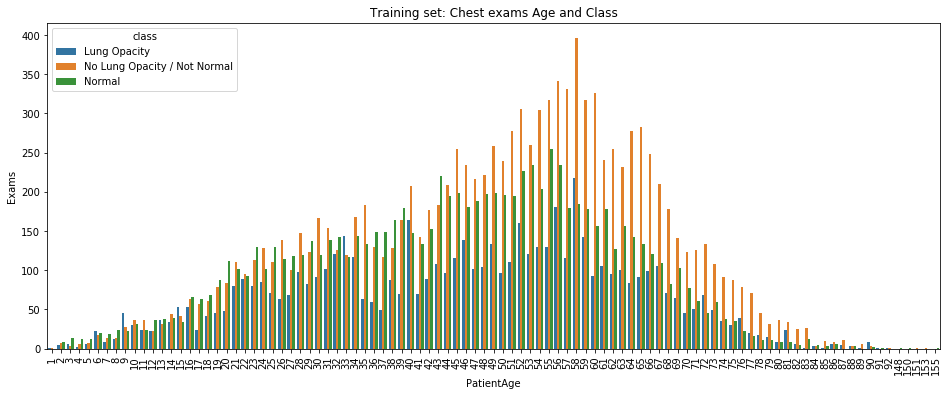

<Figure size 432x288 with 0 Axes>

In [31]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='class',data=df3)
plt.title("Training set: Chest exams Age and Class")
plt.xticks(rotation=90)
plt.show()
plt.savefig('class.png')

Note: most probably, the values of age 148 to 155 are mistakes.

Let's group the ages in 5 groups (0-19, 20-34, 35-49, 50-64 and 65+).

Patient Sex

Let's examine now the data for the Patient Sex.

We represent the number of Exams for each Patient Sex, grouped by value of Target.

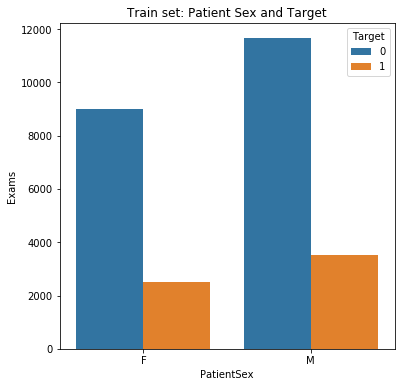

In [32]:

tmp = data.groupby(['Target', 'PatientSex'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientSex']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='Target',data=df2)
plt.title("Train set: Patient Sex and Target")
plt.show()

We represent the number of Exams for each Patient Sex, grouped by value of class.



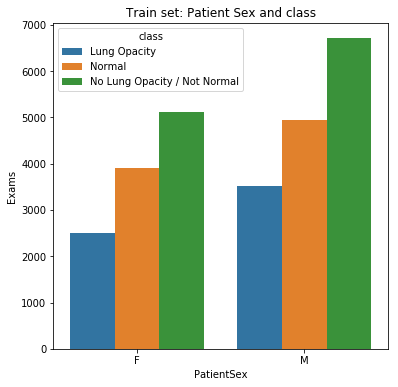

In [33]:
tmp = data.groupby(['class', 'PatientSex'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientSex']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()